In [2]:
%matplotlib inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
import random

# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
os.chdir('/users/aryanthakkar/') 
# Read in our csv files downloaded from Kaggle, 
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [5]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

In [8]:
random.seed(100)
np.random.seed(100)

train_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
train_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

test_data.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test_data.set_index(keys=['PassengerId'], drop=True, inplace=True)

train_nan_map = {'Age': train_data['Age'].mean(), 'Fare': train_data['Fare'].mean(), 'Embarked': train_data['Embarked'].mode()[0]}
test_nan_map = {'Age': test_data['Age'].mean(), 'Fare': test_data['Fare'].mean(), 'Embarked': test_data['Embarked'].mode()[0]}

train_data.fillna(value=train_nan_map, inplace=True)
test_data.fillna(value=test_nan_map, inplace=True)

columns_map = {'Embarked': {'C': 0, 'Q': 1, 'S': 2}, 'Sex': {'male': 0, 'female': 1}}
# Adding below line to surpress deprication warnings
pd.set_option('future.no_silent_downcasting', True)
train_data.replace(columns_map, inplace=True)
test_data.replace(columns_map, inplace=True)

X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)

In [9]:
print(X_train.head())
print(y_train.head())
print(test_data.head())
print(f"Test Mean: {y_test.mean()}")
print(f"Train Mean: {y_train.mean()}")

             Pclass Sex        Age  SibSp  Parch    Fare Embarked
PassengerId                                                      
464               2   0  48.000000      0      0  13.000        2
160               3   0  29.699118      8      2  69.550        2
48                3   1  29.699118      0      0   7.750        1
403               3   1  21.000000      1      0   9.825        2
619               2   1   4.000000      2      1  39.000        2
PassengerId
464    0
160    0
48     1
403    0
619    1
Name: Survived, dtype: int64
             Pclass Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                  
892               3   0  34.5      0      0   7.8292        1
893               3   1  47.0      1      0   7.0000        2
894               2   0  62.0      0      0   9.6875        1
895               3   0  27.0      0      0   8.6625        2
896               3   1  22.0      1      1  12.2875        2
Test Mean: 0.35254

In [10]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,


In [11]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid for XGBoost
param_grid = {
    "max_depth": [3, 5, 7],  
    "learning_rate": [0.01, 0.1, 0.2],  
    "n_estimators": [100, 500, 1000],  
    "subsample": [0.8, 1.0],  
    "colsample_bytree": [0.8, 1.0],  
    "gamma": [0, 0.1, 0.2],  
    "reg_alpha": [0, 0.01, 0.1],  
    "reg_lambda": [1, 10],  
}

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(objective="binary:logistic", eval_metric="logloss")

# Run grid search
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train.values, y_train.values)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}


In [112]:
from xgboost import XGBClassifier

# Initialize the XGBoost classifier
clf = XGBClassifier(colsample_bytree = 0.8, gamma = 0, learning_rate = 0.4, max_depth = 7, n_estimators = 31, reg_alpha = 0, reg_lambda = 1, subsample = 1)

# Train the classifier
clf.fit(X_train.values, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=31, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
print(clf.score(X_test.values, y_test.values))

0.823728813559322


In [89]:
y_pred = clf.predict(X_test.values)
y_truth = y_test.values

In [91]:
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)

Confusion Matrix
[[164  27]
 [ 25  79]]

True Negatives 164
False Positives 27
False Negatives 25
True Positives 79


Confusion matrix, without normalization
[[164  27]
 [ 25  79]]


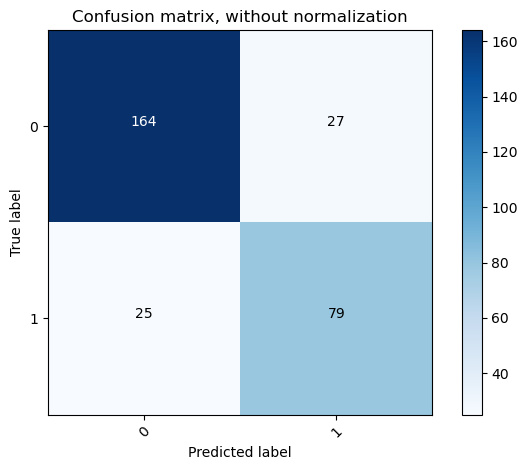

In [93]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
class_names=['0', '1']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [95]:
predictions = clf.predict(test_data.values)

In [97]:
type(predictions)
predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [19]:
type(predictions)

numpy.ndarray

In [20]:
pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
type(pred_df)

pandas.core.frame.DataFrame

In [21]:
pred_df

,Survived
PassengerId,
892,0
893,0
894,1
895,1
896,0
...,...
1305,0
1306,1
1307,0


In [22]:
pred_df.to_csv('predictions.csv', header=True, sep=',')